In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

tf.random.set_seed(1)

# [Module 60 creating and viewing classification data to model](https://youtu.be/tpCFfeUEGs8?t=33008)

### types of classification problems:
1. binary
2. multi-class
3. multi-label

In [3]:
from sklearn.datasets import make_circles

# make 100 samples
n_samples = 1000

# create circles
x, y = make_circles(n_samples, noise=0.03, random_state=1)

In [16]:
# check out features and labels. Output is 1 or 0, so it's binary classification
print(x[:10])
print(y[:10])

[[ 0.83619806  0.03563148]
 [-0.53059757 -0.6487148 ]
 [ 0.85386881 -0.61156583]
 [-0.09214707 -0.9651441 ]
 [-1.00162344  0.14446653]
 [ 0.47605284 -0.61169413]
 [-0.96305328 -0.15441694]
 [-0.54158547 -0.5311938 ]
 [-0.70570924 -0.6354933 ]
 [ 0.83579856  0.580793  ]]
[1 1 0 0 0 1 0 1 0 0]


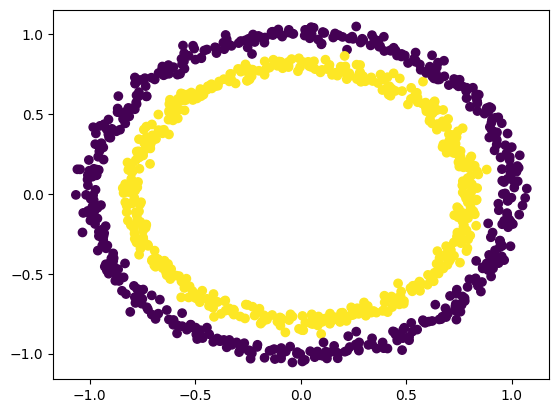

In [3]:
# put it in a dataframe for exploratory analysis
circles = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], "label": y})
# print(circles)
plt.scatter(circles["x0"], circles["x1"], c=y)
plt.show()

# [Module 61 checking the input and output shapes of our NN](https://youtu.be/tpCFfeUEGs8?t=33699)

In [6]:
# shapes:
print(x.shape, y.shape)
print(len(x), len(y))
# first example of features and labels
print(x[0], y[0])

(1000, 2) (1000,)
1000 1000
[0.83619806 0.03563148] 1


### Steps in classification problem
1. turn data into tensors (done for this problem)
2. build model
3. fit model
4. evaluate model
5. tinker with model

# [Module 62 making a non very good NN](https://youtu.be/tpCFfeUEGs8?t=33977)

In [4]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# build model
model = tf.keras.models.Sequential(
    # tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(1)
)
# compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  # use BinaryCrossentropy() for binary classification
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])  # a good classification metric

# fit data
model.fit(x_train, y_train, epochs=100, verbose=0)

# evaluate
model.evaluate(x_test, y_test)

# this model sucks! It's as bad as random guessing

2023-02-20 13:46:46.004120: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 535us/step - loss: 7.3959 - accuracy: 0.5150


[7.395880699157715, 0.5149999856948853]

In [8]:
# attempting a better model

# build
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])
# compile
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])

# fit
model2.fit(x_train, y_train, epochs=100, verbose=0)

# evaluate
model2.evaluate(x_test, y_test)
# this still sucks even with an added layer! I think changing activation function will help

7/7 [==============================] - 0s 571us/step - loss: 0.6941 - accuracy: 0.4850


[0.6940718293190002, 0.48500001430511475]

# [Module 63 Trying to improve the model](https://youtu.be/tpCFfeUEGs8?t=34708)

In [9]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation=None),
    tf.keras.layers.Dense(1, activation="relu")
])

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])

model3.fit(x_train, y_train, epochs=100, verbose=0)

model3.evaluate(x_test, y_test)
# this model still sucks!


7/7 [==============================] - 0s 578us/step - loss: 0.6957 - accuracy: 0.4450


[0.6957438588142395, 0.4449999928474426]

# [Module 64 visualizing our bad model](https://youtu.be/tpCFfeUEGs8?t=35262)

plot_decision_boundary() will
1. take in: trained model, x, y
2. create meshgrid of different x values
3. make predictions across the meshgrid
4. plot the predictions and a line between zones

In [58]:
def plot_decision_boundary(model, x, y):
    """
    Plots the decision boundary created by a model predicting on X.
    """
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html. # np.c_ translates slice objects to concat along the second axis, so [[1, 3], [2, 4]] -> [1,2,3,4]

    # Make predictions using the trained model
    y_pred = model.predict(x_in)

    # Check for multi-class
    if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 0s 260us/step
doing binary classifcation...


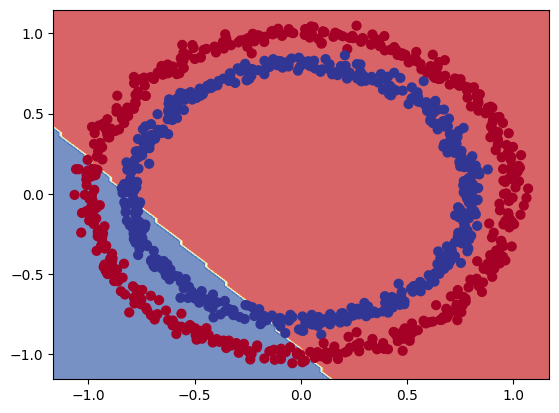

In [11]:
plot_decision_boundary(model3, x, y)
# now we can see why our model sucks, it's trying to make a linear decision boundary

# [Module 65 trying our bad (linear) model for a regression problem](https://youtu.be/tpCFfeUEGs8?t=36170)
### This is the final video in part 1! Over 10 hours in!

In [5]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="blue", label="Training Data")
    plt.scatter(test_data, test_labels, c="green", label="Testing Data")
    plt.scatter(test_data, predictions, c="red", label="Predictions")
    plt.legend()
    plt.show()

2/2 [==============================] - 0s 1ms/step


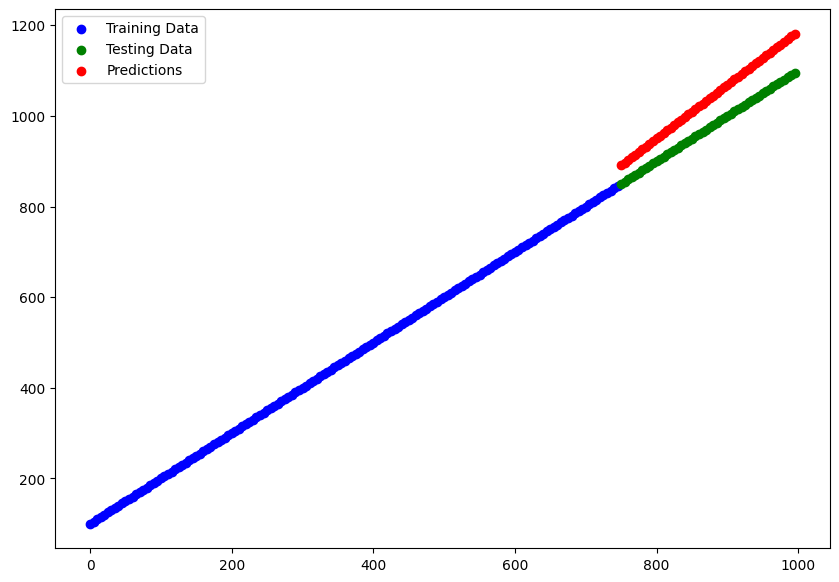

In [29]:
# create regression data
x_reg = np.arange(0, 1000, 5)
y_reg = x_reg + 100

x_train_reg, x_test_reg = x_reg[:150], x_reg[150:]
y_train_reg, y_test_reg = y_reg[:150], y_reg[150:]

# fit it to the model
# model3.fit(x_train, y_train, epochs=100) # this has a shape issue because we made our model before for 2 inputs. binarycrossentropy doesn't make sense for regression

# let's make a better model
# design model
model4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,)), # not sure why I needed to specify this here, but it's a good thing to try if I get shape errors
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])

# compile
model4.compile(loss=tf.keras.losses.mae,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

# fit
model4.fit(x_train_reg, y_train_reg, epochs=50, verbose=0)

# make predictions
y_pred_reg = model4.predict(x_test_reg)

# plot predictions
plot_predictions(x_train_reg, y_train_reg, x_test_reg, y_test_reg, y_pred_reg)

# [Module 66 non-linearity part 1](https://youtu.be/ZUKz4125WNI?t=55)
combined with
# [Module 66 non-linearity part 2: building our first non-linear NN](https://youtu.be/ZUKz4125WNI?t=633)


In [40]:
# making a model that is non-linear

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(1)
])

model4.compile(loss=tf.keras.losses.mae,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model4.fit(x_train, y_train, epochs=100, verbose=0)

y_pred = model4.predict(x_test)

plot_decision_boundary(model4, x_test, y_pred)  # looks weird but closer

# [Module 67 non-linearity part 3 upgrading non-linear model with more layers](https://youtu.be/ZUKz4125WNI?t=981)
I already did most of this on my own in the above cells. Went till module 69

In [27]:
# a model with different output activation

model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model5.fit(x_train, y_train, epochs=100, verbose=0)
y_pred = model5.predict(x_test)

plot_decision_boundary(model5, x_test, y_pred)  # looks great!!

7/7 [==============================] - 0s 419us/step


NameError: name 'plot_decision_boundary' is not defined

# [Module 70: non-linearity part 5 reproducing our non-linear model from scratch](https://youtu.be/ZUKz4125WNI?t=2118)

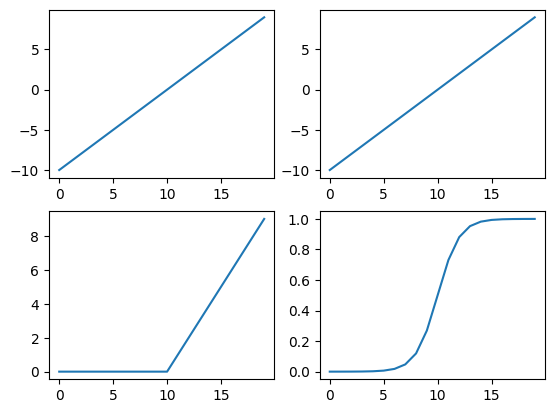

In [22]:
# make a toy tensor
A = tf.cast(tf.range(-10, 10), tf.float32)




fig, ax = plt.subplots(2, 2)
ax[0][0].plot(A)
ax[0][1].plot(tf.keras.activations.linear(A)) # doesn't modify the input
ax[1][0].plot(tf.nn.relu(A)) # sigmoid is 1/ (1+e**x)
ax[1][1].plot(tf.sigmoid(A)) # relu is (0 if x < 0, else x)

# [Module 71: getting great results in less time by changing learning rate](https://youtu.be/ZUKz4125WNI?t=2985)

7/7 [==============================] - 0s 884us/step - loss: 0.0203 - accuracy: 0.9900
[0.020333459600806236, 0.9900000095367432]
313/313 [==============================] - 0s 269us/step
doing binary classifcation...


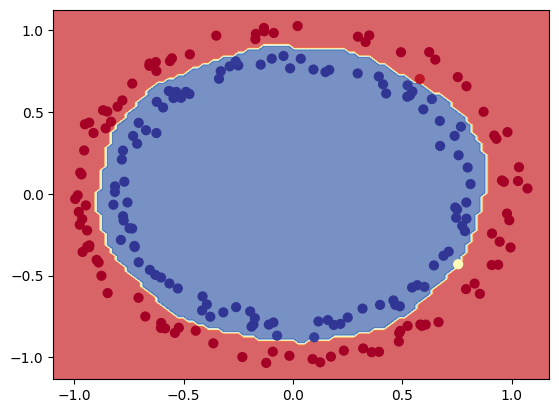

In [38]:
# evaluating and improving our classification model
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["accuracy"])

history = model6.fit(x_train, y_train, epochs=75, verbose=0)
y_pred = model6.predict(x_test)

# evaluate
print(model6.evaluate(x_test, y_test))

plot_decision_boundary(model6, x_test, y_pred)
# plot_decision_boundary(model6, x_train, y_train)

# [Module 72: using history object to plot a model's loss curves](https://youtu.be/ZUKz4125WNI?t=3872)

Text(0.5, 1.0, 'loss curves')

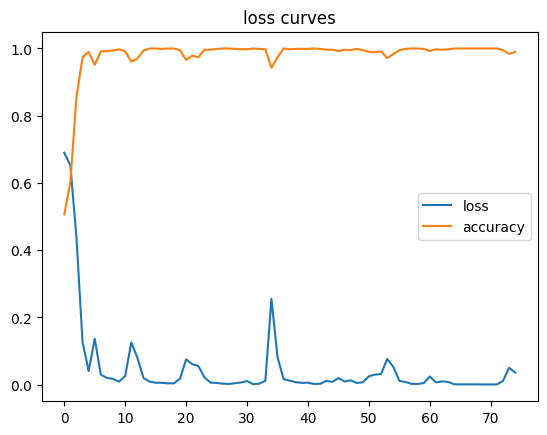

In [40]:
# plot loss curves
pd.DataFrame(history.history).plot()
plt.title("loss curves")

# loss function is how wrong the model is. loss function going down is good

# [Module 73: using callbacks to find optimal learning rate](https://youtu.be/ZUKz4125WNI?t=4243)
ideal learning rate is learning rate where loss decreases the most during training.
We'll follow these steps
- learning rate callback is an extra piece of functionality you can add to your model during training
- another model
- modified loss curves plot

<Axes: xlabel='epochs'>

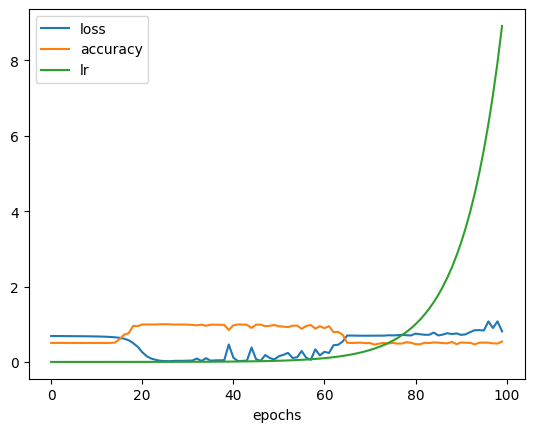

In [51]:
# same as model6 in design and compile steps
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# create learning rate callback before fitting
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history7 = model7.fit(x_train, y_train, epochs=100, verbose=0, callbacks=[lr_scheduler]) # wait a second why does adding callbacks make it suck?

# check history:
pd.DataFrame(history7.history).plot(xlabel="epochs")

Text(0.5, 1.0, 'Learning rate vs. loss')

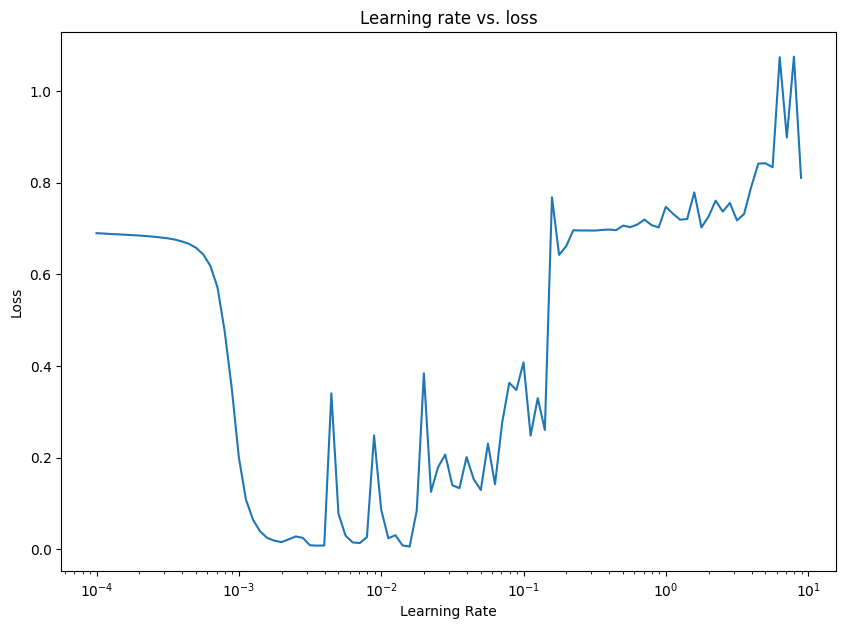

In [50]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history7.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss")

want an area where learning rate is going down very quickly (so very negative derivative, I guess). around 10^-3 or a little bigger then

# [Module 74: training and evaluating a model with optimal learning rate](https://youtu.be/ZUKz4125WNI?t=5296)

Epoch 1/20
25/25 [==============================] - 0s 523us/step - loss: 0.6885 - accuracy: 0.5038 - lr: 1.0000e-04
Epoch 2/20
25/25 [==============================] - 0s 513us/step - loss: 0.6880 - accuracy: 0.5038 - lr: 1.1220e-04
Epoch 3/20
25/25 [==============================] - 0s 452us/step - loss: 0.6874 - accuracy: 0.5038 - lr: 1.2589e-04
Epoch 4/20
25/25 [==============================] - 0s 460us/step - loss: 0.6869 - accuracy: 0.5038 - lr: 1.4125e-04
Epoch 5/20
25/25 [==============================] - 0s 421us/step - loss: 0.6862 - accuracy: 0.5038 - lr: 1.5849e-04
Epoch 6/20
25/25 [==============================] - 0s 445us/step - loss: 0.6855 - accuracy: 0.5038 - lr: 1.7783e-04
Epoch 7/20
25/25 [==============================] - 0s 426us/step - loss: 0.6847 - accuracy: 0.5038 - lr: 1.9953e-04
Epoch 8/20
25/25 [==============================] - 0s 471us/step - loss: 0.6836 - accuracy: 0.5038 - lr: 2.2387e-04
Epoch 9/20
25/25 [==============================] - 0s 453us/ste

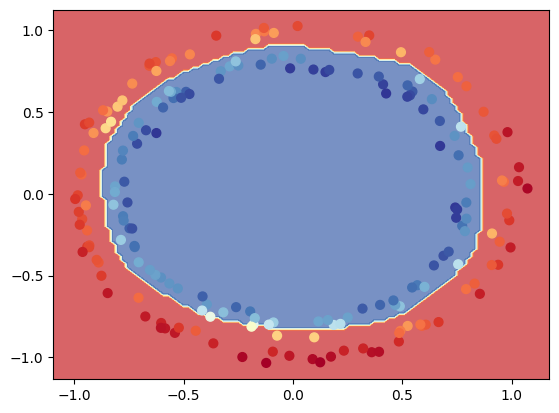

In [68]:
# same as model8 in design and compile steps
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(50, activation="ReLU"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model8.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
               metrics=["accuracy"])

# create learning rate callback before fitting
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history8 = model8.fit(x_train, y_train, epochs=20, verbose=1, callbacks=[lr_scheduler])  # we can use fewer epochs with our better learning rate

print(f"evaluation = {model8.evaluate(x_test, y_test)}")
y_pred = model8.predict(x_test)
plot_decision_boundary(model8, x_test, y_pred)